# First, download the data

In [1]:
import requests
import os
import gzip
import shutil

def download_file(url, filename):
    """
    Helper function to download a file from a URL and save it locally.
    """
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.raw.read())
    else:
        print(f"Failed to download file: Status code {response.status_code}\nURL: {url}")

def decompress_gz(source_filepath, dest_filepath):
    """
    Decompresses a gzip file to a destination file path.
    """
    with gzip.open(source_filepath, 'rb') as f_in:
        with open(dest_filepath, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

os.makedirs("data", exist_ok=True)
data_dir = 'data/raw'  # Adjust the path according to your project structure
os.makedirs(data_dir, exist_ok=True)

# File URLs and paths
files = {
    'TPM_matrix': {
        'url': 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75688/suppl/GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz',
        'gz_path': 'GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz',
        'final_path': 'GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt'
    },
    'sample_info': {
        'url': 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75688/suppl/GSE75688_final_sample_information.txt.gz',
        'gz_path': 'GSE75688_final_sample_information.txt.gz',
        'final_path': 'GSE75688_final_sample_information.txt'
    }
}

for key, file_info in files.items():
    gz_file_path = os.path.join(data_dir, file_info['gz_path'])
    decompressed_file_path = os.path.join(data_dir, file_info['final_path'])

    # Download the file
    print(f"Downloading {key}...")
    download_file(file_info['url'], gz_file_path)

    # Decompress the file
    print(f"Decompressing {key}...")
    decompress_gz(gz_file_path, decompressed_file_path)

    print(f"{key} downloaded and decompressed successfully.")


Decompressing TPM_matrix...
TPM_matrix downloaded and decompressed successfully.
Decompressing sample_info...
sample_info downloaded and decompressed successfully.


# Data Preprocessing and Saving

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def load_data(tpm_path, sample_info_path):
    """Load TPM matrix and sample information."""
    tpm_matrix = pd.read_csv(tpm_path, sep='\t', index_col=0)
    sample_info = pd.read_csv(sample_info_path, sep='\t', index_col=0)
    return tpm_matrix, sample_info

def preprocess_tpm_matrix(tpm_matrix):
    """Transpose TPM matrix and drop unnecessary initial rows."""
    tpm_transposed = tpm_matrix.T
    # Remove the first two rows which contain 'gene_name' and 'gene_type'
    tpm_transposed = tpm_transposed[2:] 
    return tpm_transposed

def map_subtypes(tpm_transposed):
    """Map samples to their subtypes."""
    subtype_mapping = {
        'BC01': 'ER+', 'BC02': 'ER+', 'BC03': 'ER+HER2+',
        'BC03LN': 'ER+HER2+ LN metastasis', 'BC04': 'HER2+',
        'BC05': 'HER2+', 'BC06': 'HER2+', 'BC07': 'TNBC',
        'BC07LN': 'TNBC LN metastasis', 'BC08': 'TNBC',
        'BC09': 'TNBC', 'BC10': 'TNBC', 'BC11': 'TNBC',
    }
    sample_subtypes = {sample: subtype_mapping[sample.split('_')[0]] for sample in tpm_transposed.index}
    tpm_transposed['subtype'] = pd.Series(sample_subtypes)
    return tpm_transposed

def prepare_data(tpm_transposed):
    """Prepare data for training."""
    X = tpm_transposed.drop('subtype', axis=1)
    y = tpm_transposed['subtype']
    
    # Scaling features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # X_scaled = X
    
    return X_scaled, y

# File paths
tpm_path = 'data/raw/GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt'
sample_info_path = 'data/raw/GSE75688_final_sample_information.txt'

# Load data
tpm_matrix, sample_info = load_data(tpm_path, sample_info_path)
# drop the gene EC2 from tpm_matrix, as found that that gene has extraordinarily high variance and will
# mess up downstream analyses (it is at row 57912)
tpm_matrix.drop('SPIKE1', inplace=True) # SPIKE1 is the row label at that row (dropping with index wasn't working)
tpm_transposed = preprocess_tpm_matrix(tpm_matrix)
tpm_transposed = map_subtypes(tpm_transposed)

# get X and y arrays without standardization (as need to select highly var genes then do standardization)
X_orig = tpm_transposed.drop('subtype', axis=1).values
y_orig = tpm_transposed['subtype']

# Prepare data
# X_orig, y_orig = prepare_data(tpm_transposed)

# Create processed data directory
# processed_data_dir = 'data/processed'
# os.makedirs(processed_data_dir, exist_ok=True)

# Save processed data
# np.save(os.path.join(processed_data_dir, 'X.npy'), X_orig)
# np.save(os.path.join(processed_data_dir, 'y.npy'), y_orig)

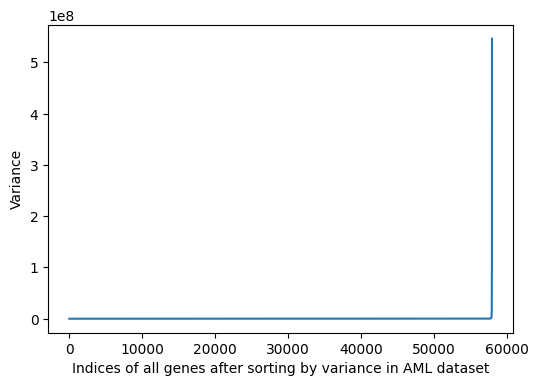

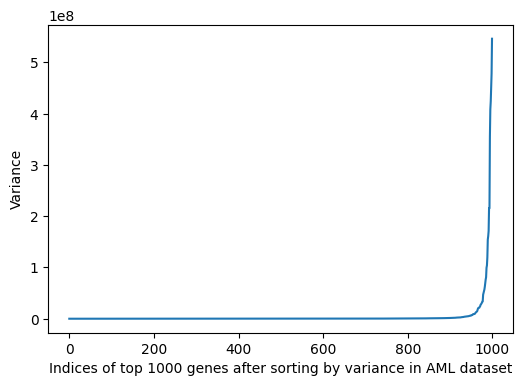

In [3]:
# Only keeping the highly variable genes 

num_genes = 1000
# find num_genes genes with top variance for the given dataset
top_n_variance_genes_indices = np.argsort(np.var(X_orig, axis=0))[::-1] # sorted descendingly
top_n_variance_genes = tpm_matrix['gene_name'][top_n_variance_genes_indices][:num_genes]
X = X_orig[:,top_n_variance_genes_indices[:num_genes]]

import matplotlib.pyplot as plt
# an illustration of the variance of the different genes for X
# NOTE that only last few thousand genes have very high variance, whereas others dont have much

# figsize adjust
size = (6,4)
plt.figure(figsize=size)
plt.plot(sorted(np.var(X_orig, axis=0)))
plt.xlabel('Indices of all genes after sorting by variance in AML dataset')
plt.ylabel('Variance')
plt.show()

plt.figure(figsize=size)
plt.plot(sorted(np.var(X_orig, axis=0))[-1000:])
plt.xlabel('Indices of top 1000 genes after sorting by variance in AML dataset')
plt.ylabel('Variance')
plt.show()

In [4]:
# standardize the data now
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y_orig

# Perform PCA

In [5]:
# PCA functions

def eigendecomp(df):
    ''' 
    eigendecomp takes a dataframe df and returns the eigenvalues and eigenvectors of the covariance matrix of df.
    '''
    # Centering
    df_centered = df - df.mean(axis=0)
    # Covariance matrix
    # S = np.cov(df_centered)
    S = np.dot(df_centered.T, df_centered) / (df_centered.shape[0] - 1)
    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(S)
    # Sort eigenvectors by eigenvalues in descending order
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    return eigvals, eigvecs

def project_data(df, eigvecs, n_components=2):
    ''' 
    project_data takes a dataframe df and eigenvectors and returns the projected data.
    '''
    # Centering
    df_centered = df - df.mean(axis=0)
    # Project data onto eigenvectors
    return np.dot(df_centered, eigvecs[:, :n_components])

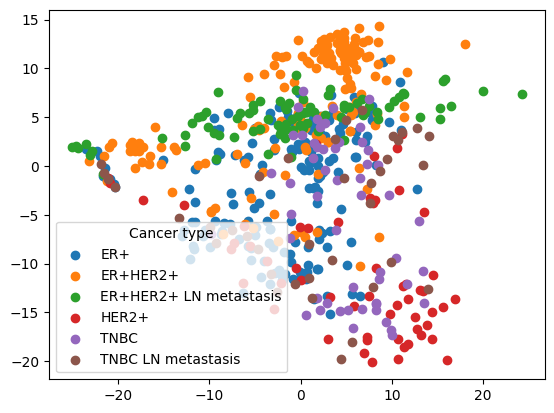

In [6]:
# perform eigen decomposition and plot PCA plots

eigvals, eigvecs = eigendecomp(X)

# make a modified label array, which will be used for coloring in the plot
y_nums, y_uniqs = pd.factorize(y)

# plot scatterplot, with the original labels

data_X_projected = project_data(X, eigvecs, n_components=2)

# loop through all the points in groups of (known) labels and make their scatterplot
for itr, cancer_type in enumerate(y.value_counts().index):
    subset_mask = y==cancer_type
    subset = data_X_projected[subset_mask]
    plt.scatter(subset[:,0], subset[:,1], label = y_uniqs[itr])
plt.legend(title='Cancer type')
plt.show()

# Perform K-means

In [7]:
# K means functions related functions 

def distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

def objective(data, means, clusters, K):
    objective = 0
    for k in range(K):
        for i in range(data.shape[0]):
            if clusters[i] == k:
                # Add the squared distance from X and its cluster's centroid to the objective
                objective += np.sum(distance(data[i],means[k])**2)
    return objective

def reestimate_means(data, clusters, K):
    means = np.zeros((K, data.shape[1]))
    for k in range(K):
        means[k] = np.mean(data[clusters == k], axis=0)
    return means

def kmeans(data, init_means, K, max_iter=100):
    # convert data from pd to np
    # data = data.values
    means = []
    for i in range(K):
        means.append(init_means[i])
    means = np.array(means)
    clusters = np.zeros(data.shape[0])
    objective_values = []
    objective_values.append(objective(data, means, clusters, K))
    for i in range(max_iter):
        if i % 5 == 0:
            print("Iteration",i)
        # Assign each point to the closest mean
        for j in range(data.shape[0]):
            clusters[j] = np.argmin(np.sum((means - data[j])**2, axis=1))
        # Reestimate the means
        means = reestimate_means(data, clusters, K)
        # Compute the objective
        objective_values.append(objective(data, means, clusters, K))
        # Check for convergence
        if objective_values[-1] == objective_values[-2]:
            break
    return objective_values, clusters

In [8]:
# perform k means

k = 6 # number of clusters in k means (as there are 6 classes in our dataset)

np.random.seed(13) # 13 good
random_datapts = np.random.choice(X.shape[0], size=k) # cols means samples here
random_means = X[random_datapts, :]
# Run the K-means algorithm
objective_values, clusters = kmeans(X, random_means, k)

Iteration 0
Iteration 5
Iteration 10


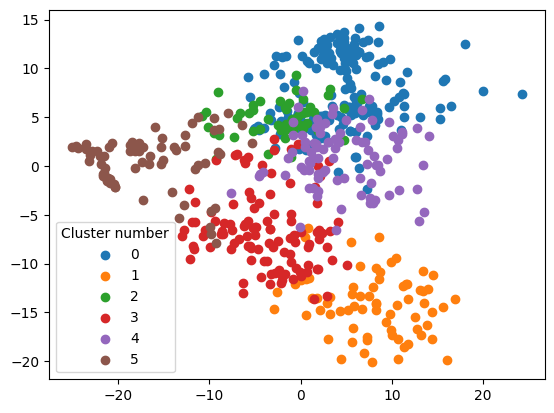

In [9]:
# Plot the reduced data with K-means clusters as colors
# loop through all the points in groups of (known) labels and make their scatterplot
for cluster in range(6):
    subset_mask = clusters==cluster
    subset = data_X_projected[subset_mask]
    plt.scatter(subset[:,0], subset[:,1], label = str(cluster))
plt.legend(title='Cluster number')
plt.show()

In [14]:
# Calculate ARI score between our clustering and original clustering
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(clusters, y_nums)

0.2886694164118354

# Feature Identification using Logistic Regression model

In [10]:
# Split the data into training and test sets, and scale the X_train and X_test

X_train, X_test, y_train, y_test = train_test_split(X, clusters, test_size=0.2, train_size=0.8)

# initialize and fit the logistic regression model
logreg = LogisticRegression('l1', C=1.0, solver='liblinear', random_state=42)
logreg.fit(X_train, y_train)
# now logreg.coef_ has the importance weights for all the features

# list of genes in decreasing order of importance
genes_of_interest = top_n_variance_genes[np.argsort(np.sum(logreg.coef_, axis = 0))[::-1]]
indices_of_genes_interest = np.argsort(np.sum(logreg.coef_, axis = 0))[::-1]

In [11]:
from ClassificationReport import ClassificationMetrics
# Predict on the testing data
y_pred = logreg.predict(X_test)

# Evaluate the classifier performance
#print(classification_report(y_test, y_pred, num_classes))
#classification_report_categorical(y_test, y_pred)
metrics = ClassificationMetrics(y_test, y_pred)
metrics.report()

ClassPrecision Recall    F1-Score  Class Accuracy Instances 
0.0  0.87      1.00      0.93      1.00           27        
1.0  1.00      0.89      0.94      0.89           19        
2.0  1.00      0.88      0.93      0.88           8         
3.0  0.91      0.91      0.91      0.91           22        
4.0  1.00      0.91      0.95      0.91           22        
5.0  0.88      0.93      0.90      0.93           15        

Overall Accuracy:             0.93


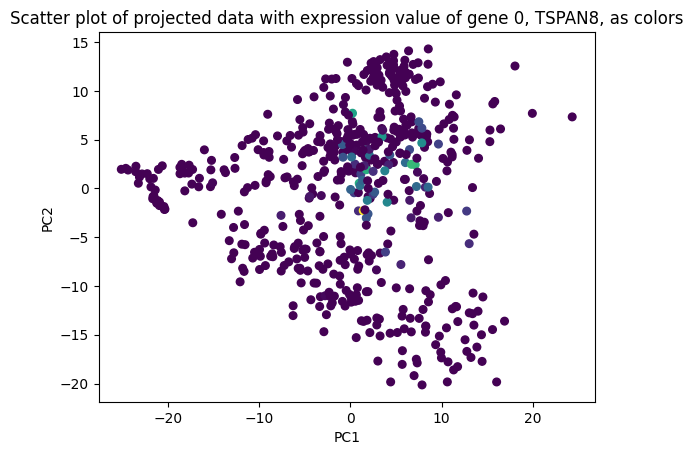

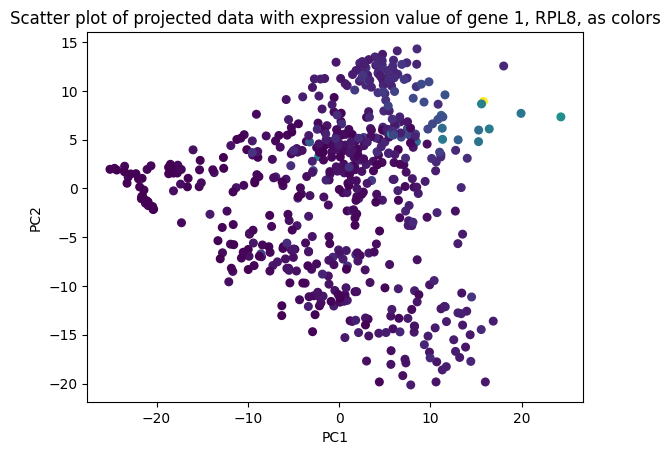

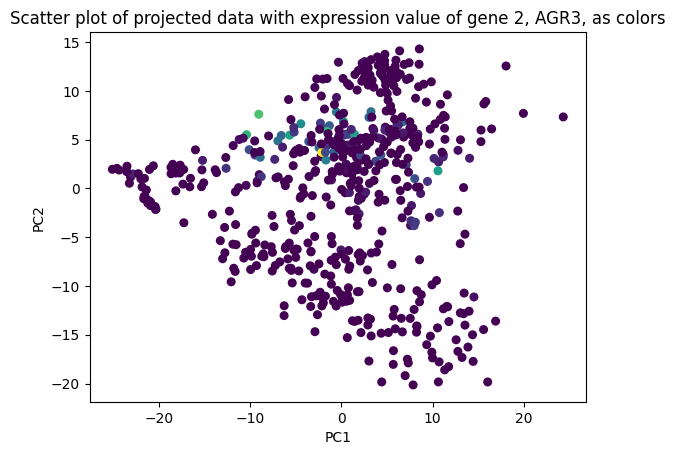

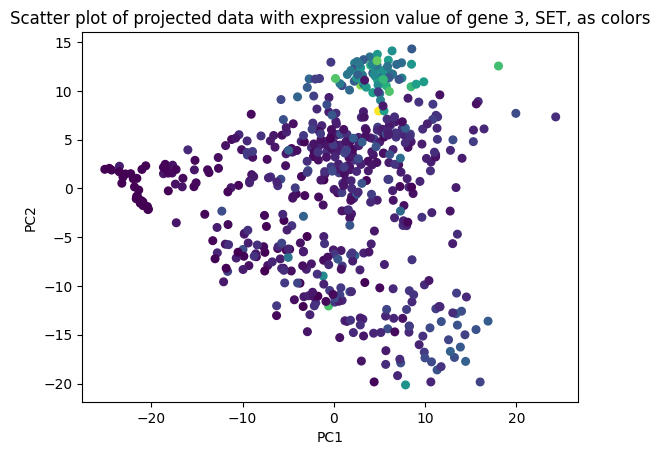

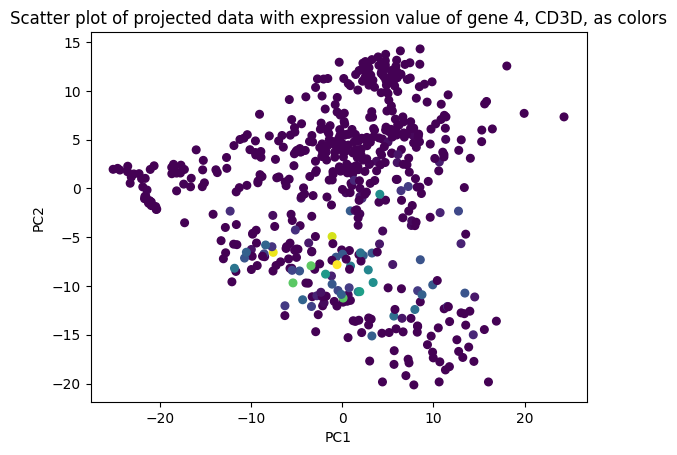

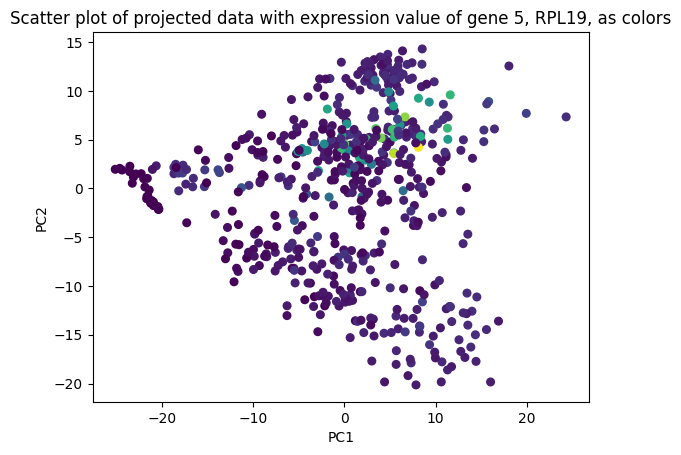

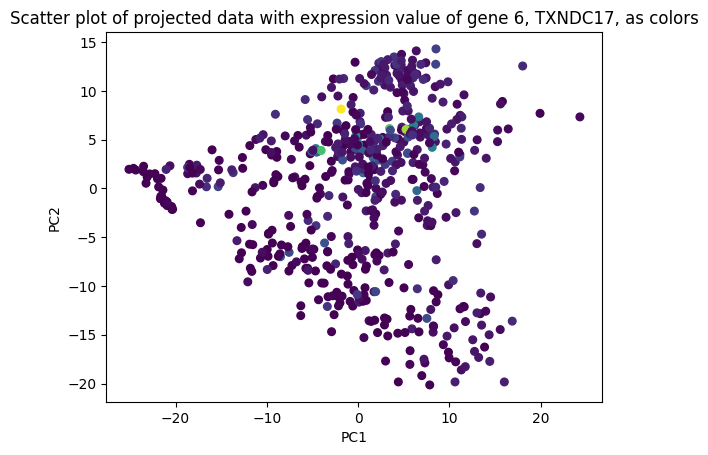

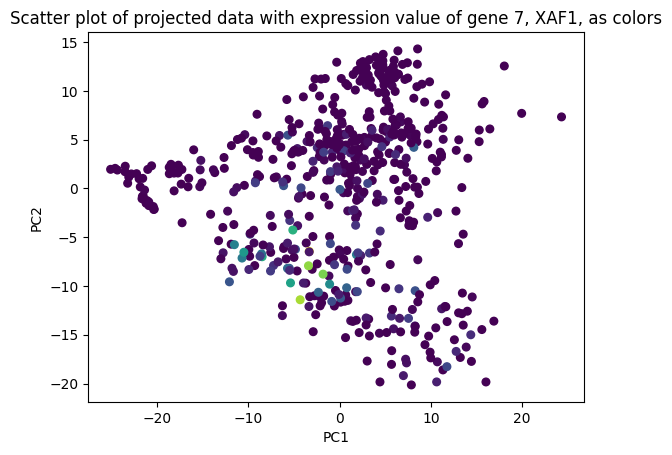

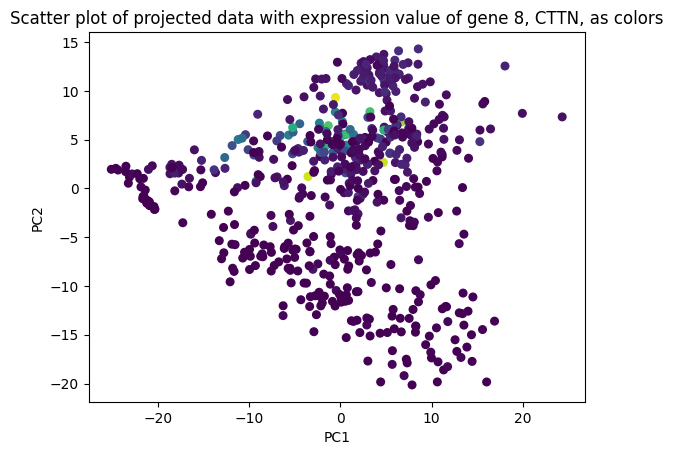

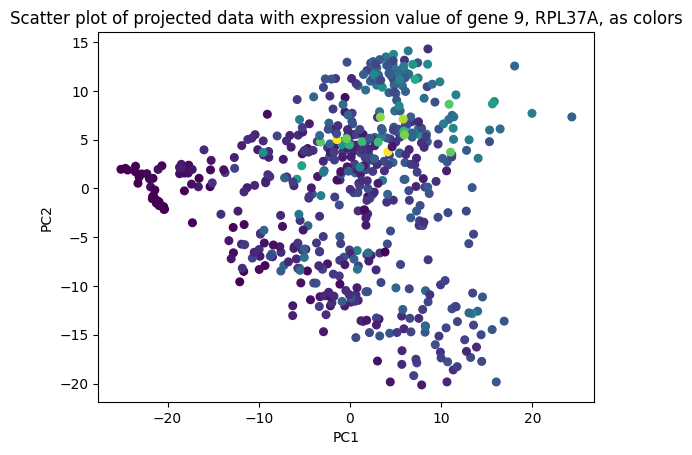

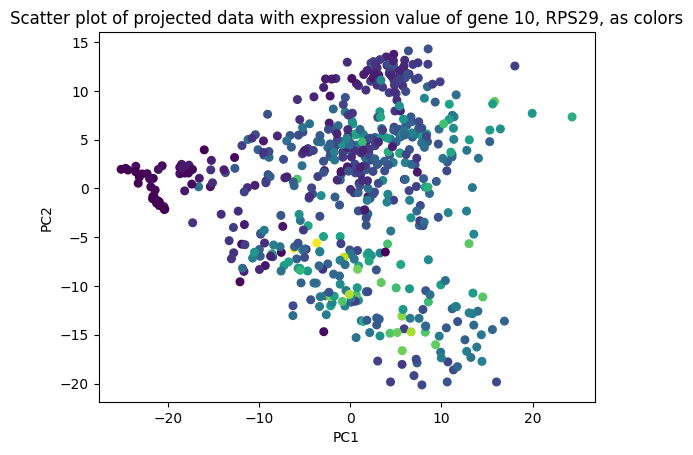

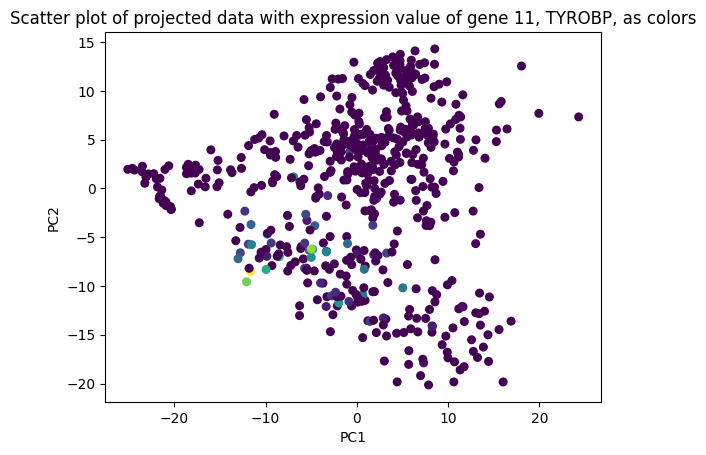

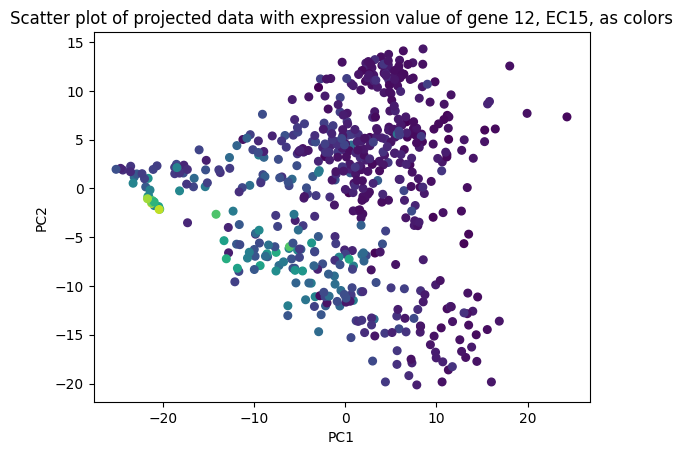

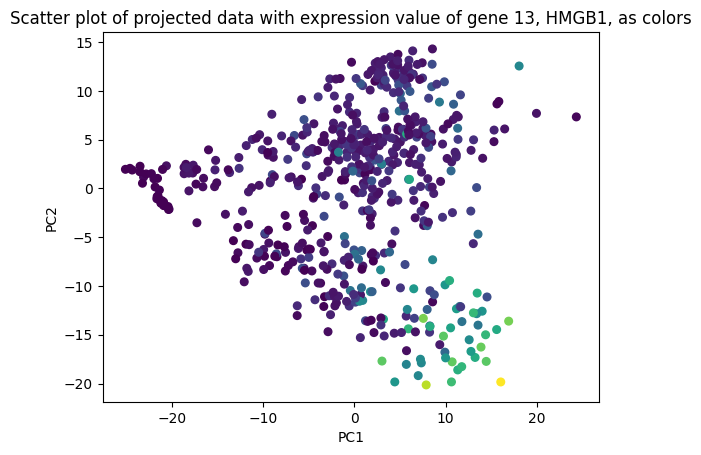

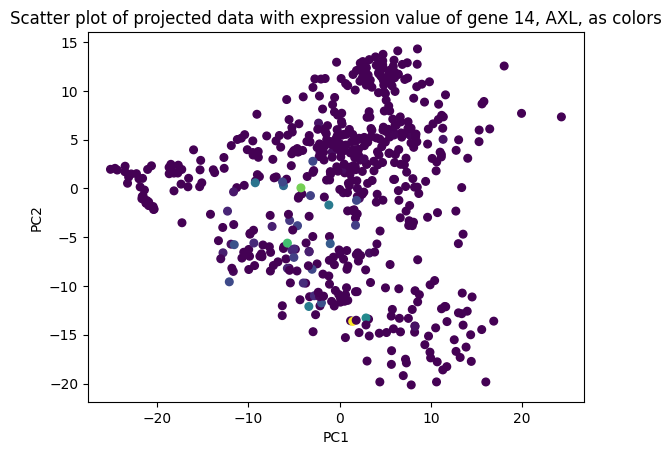

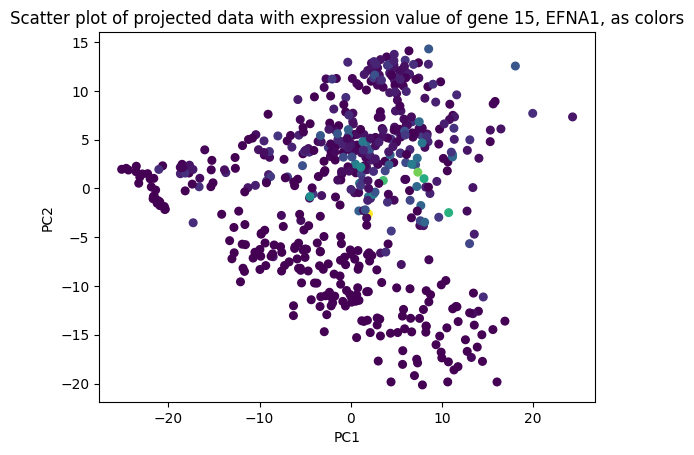

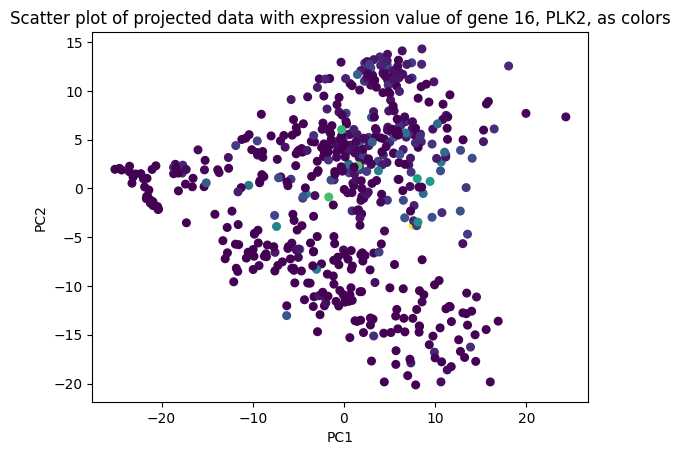

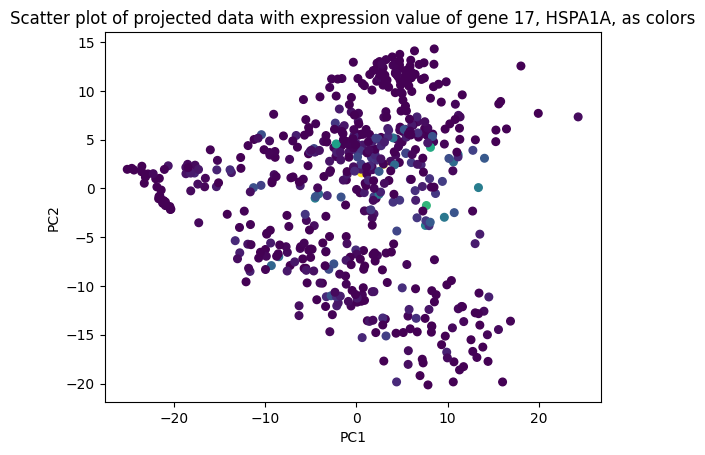

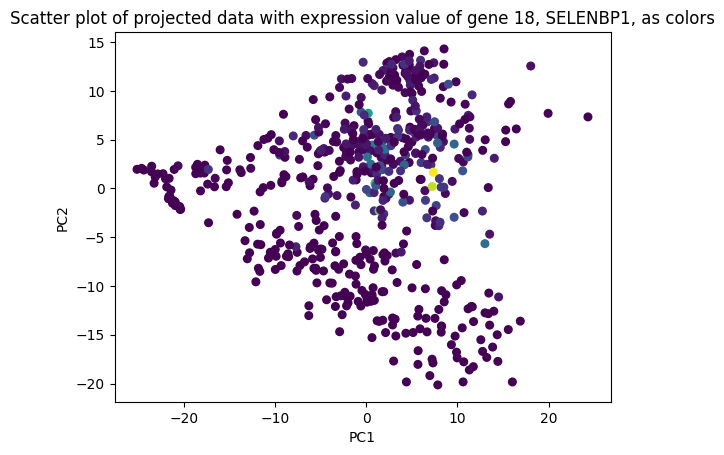

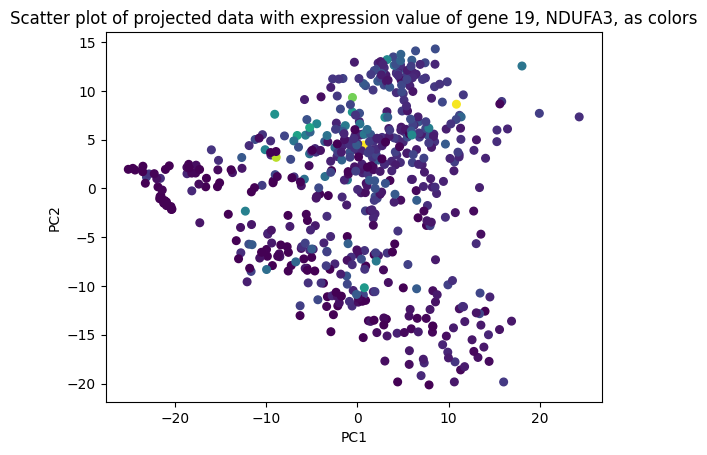

In [12]:
# plot the expression values for top few genes in the scatter plot to see how differetiated its 
# expression is
for i in range(0, 20, 1):
    gene_of_interest_expressions = X[:,indices_of_genes_interest[i]]
    ## scatter plot showing the expression levels of the top 20 found important genes of interest in samples
    plt.scatter(data_X_projected[:, 0], data_X_projected[:, 1], c=gene_of_interest_expressions, s=30)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'Scatter plot of projected data with expression value of gene {i}, {genes_of_interest[i]}, as colors')
    plt.show()

# Feature Identification using Random Forest Model

In [89]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)
# Predict on the testing data
y_pred = rf_classifier.predict(X_test)
# Evaluate
metrics = ClassificationMetrics(y_test, y_pred)
metrics.report()

Class                         Precision Recall    F1-Score  
0.0                           0.85      0.94      0.89      
1.0                           1.00      1.00      1.00      
2.0                           1.00      1.00      1.00      
3.0                           0.84      0.95      0.89      
4.0                           1.00      0.87      0.93      
5.0                           1.00      0.80      0.89      

Overall Accuracy:             0.92


In [98]:
# list of genes in decreasing order of importance
genes_of_interest2 = top_n_variance_genes[np.argsort(rf_classifier.feature_importances_)[::-1]]
indices_of_genes_interest2 = np.argsort(rf_classifier.feature_importances_)[::-1]

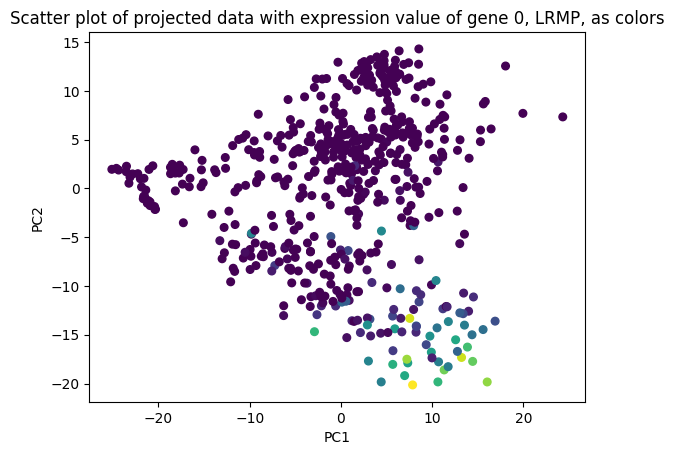

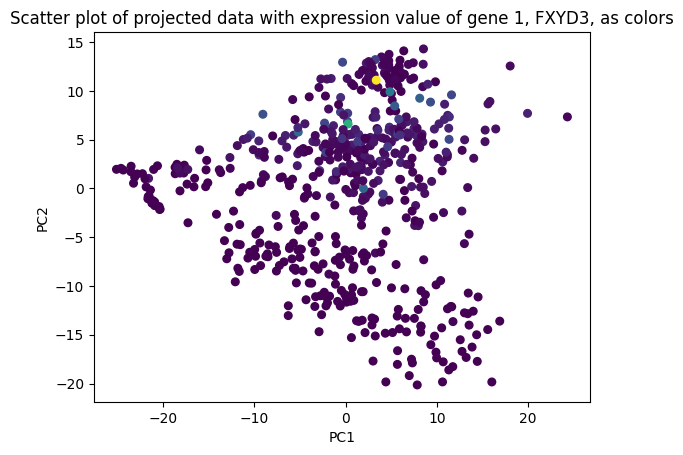

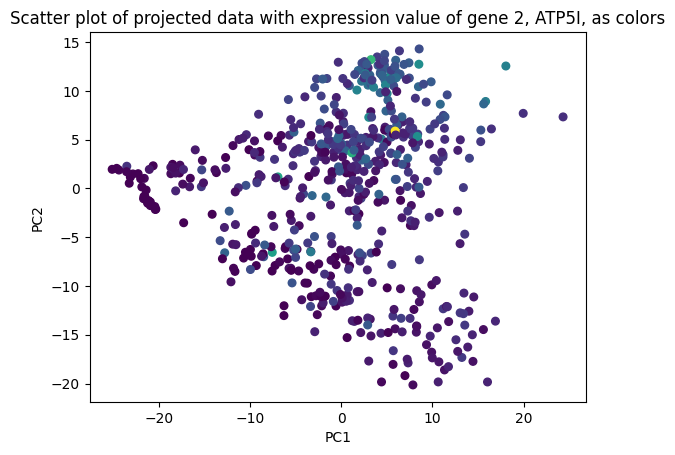

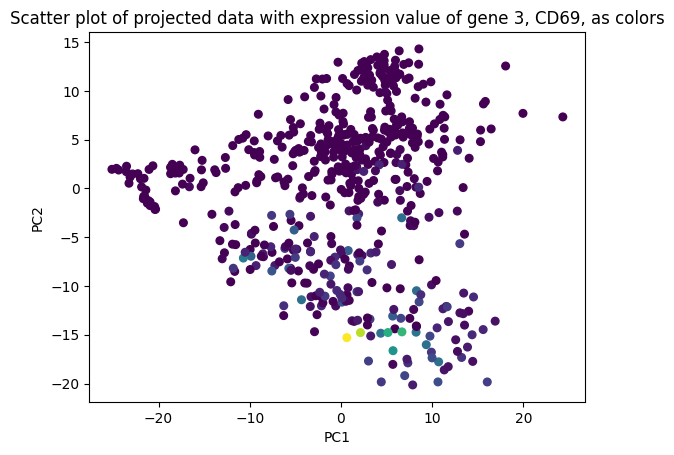

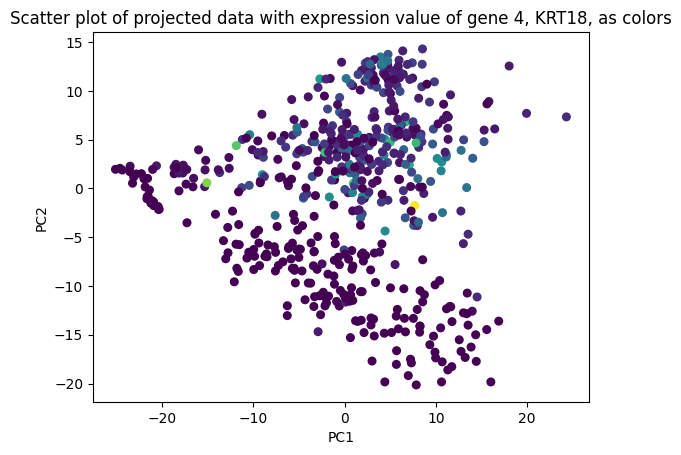

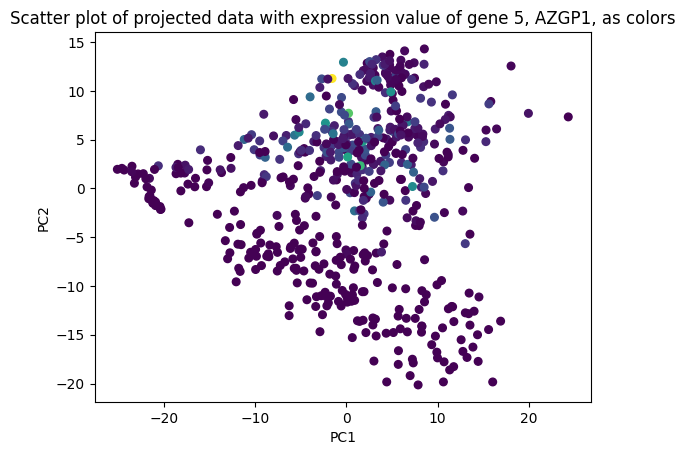

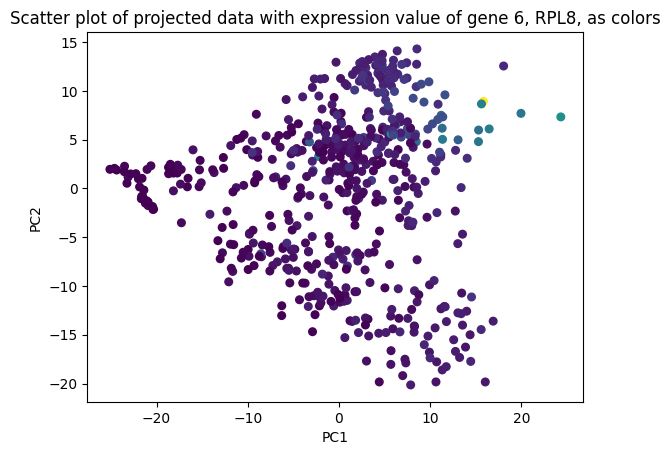

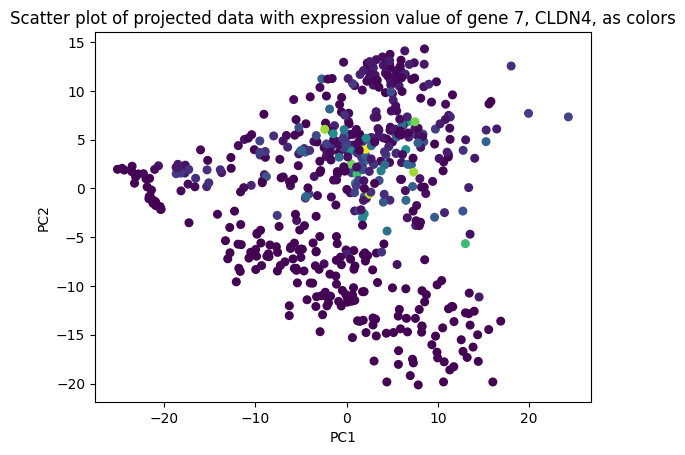

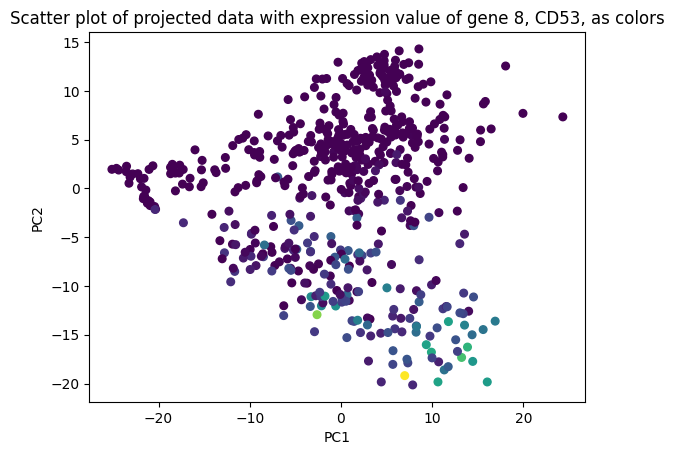

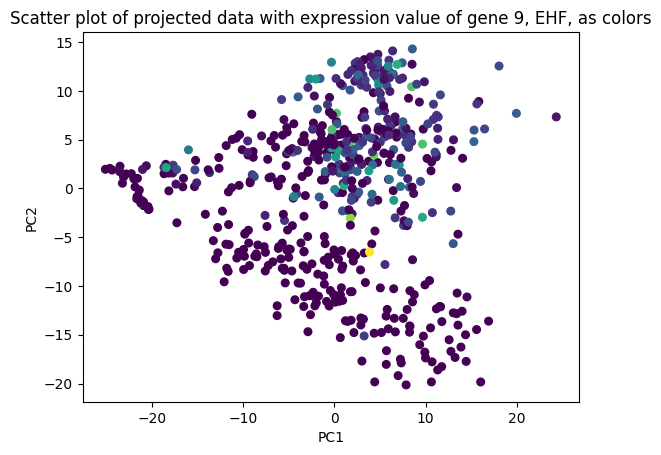

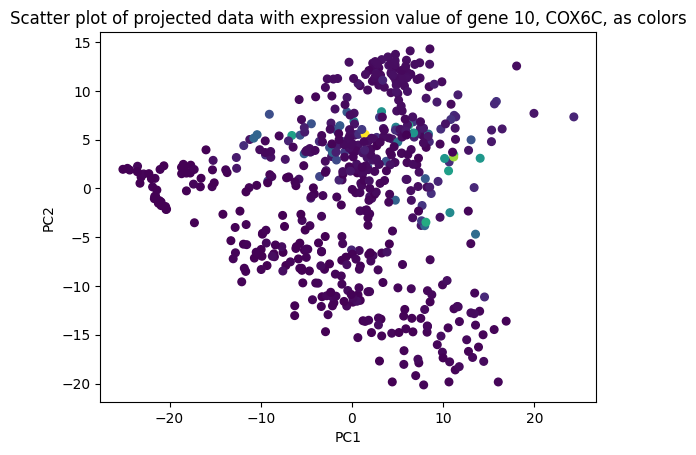

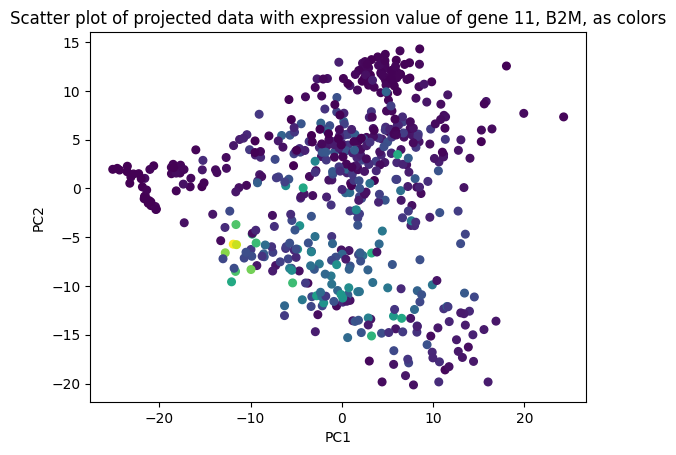

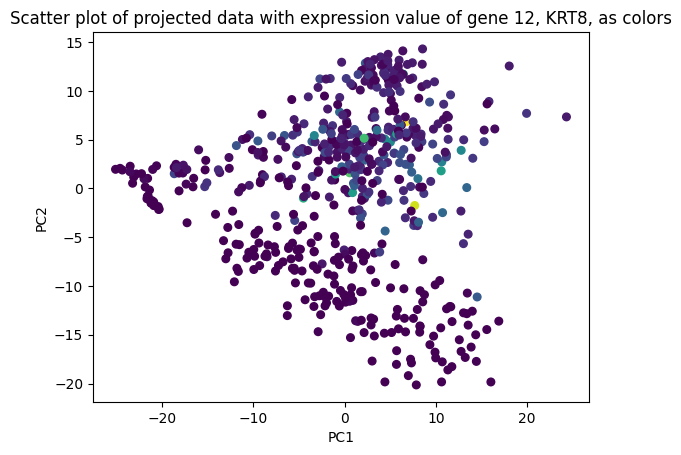

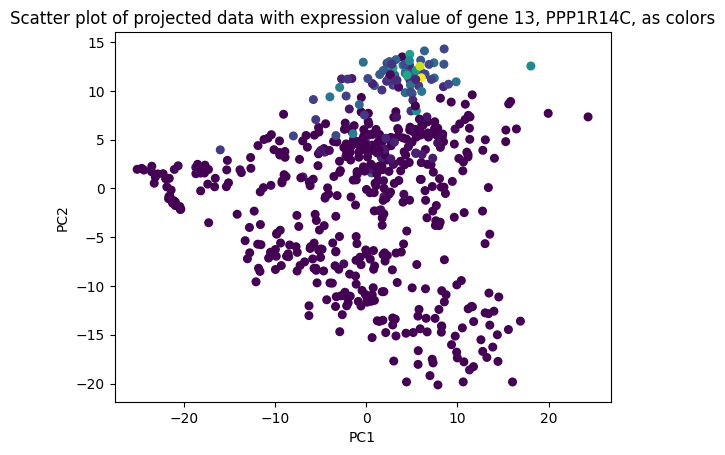

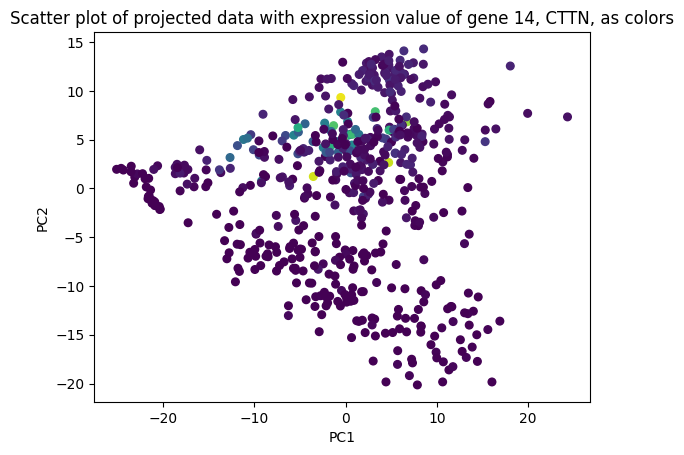

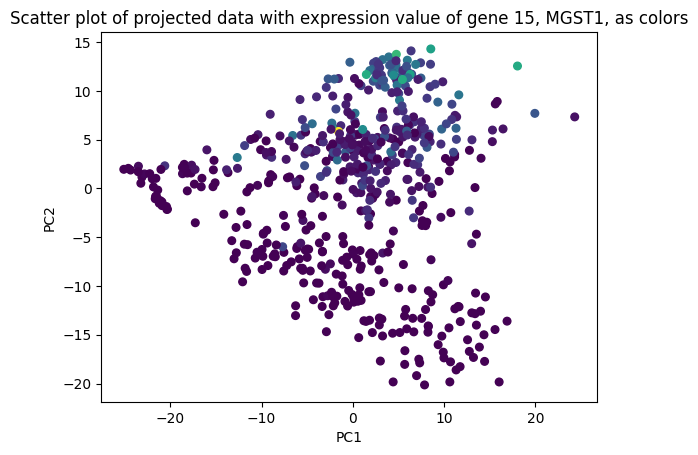

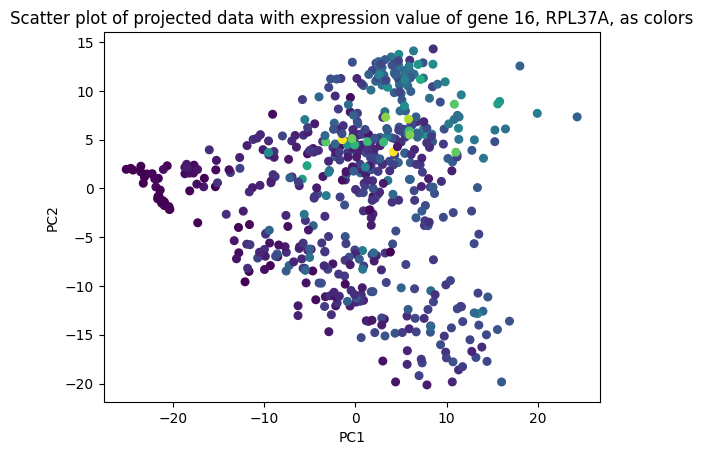

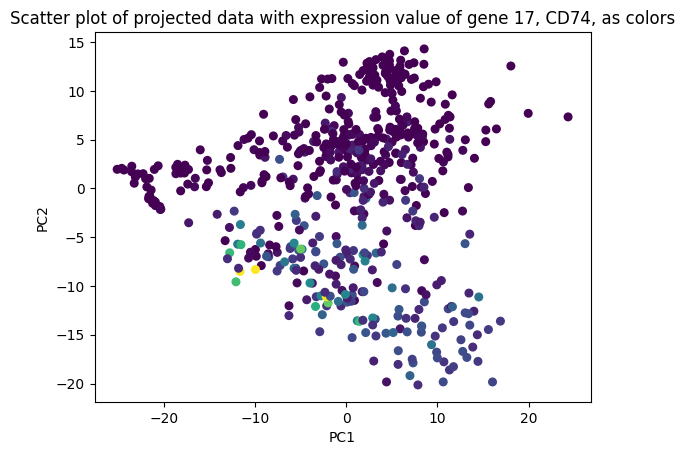

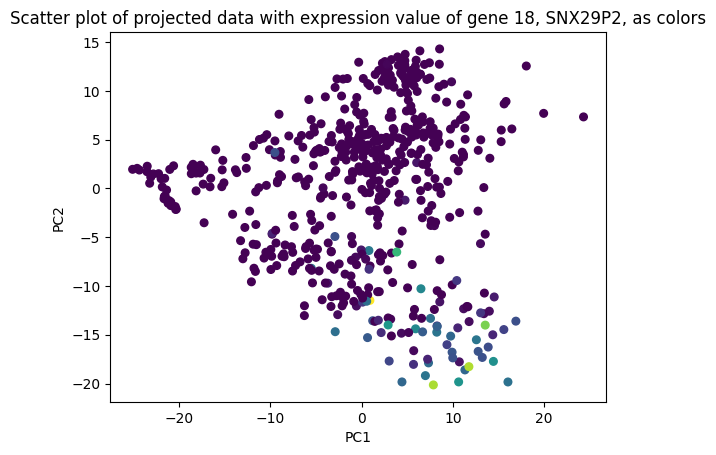

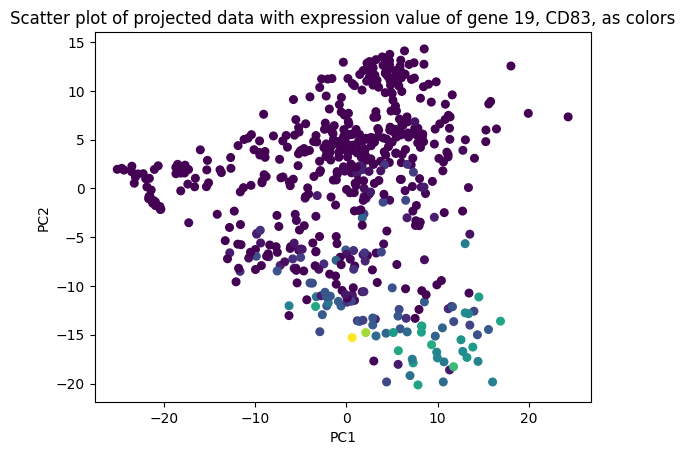

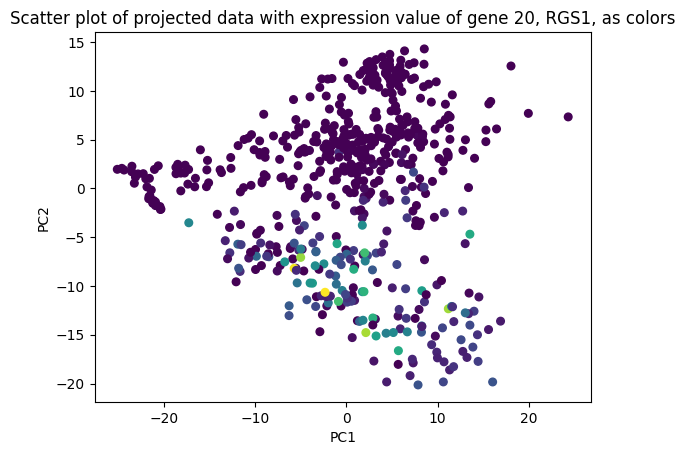

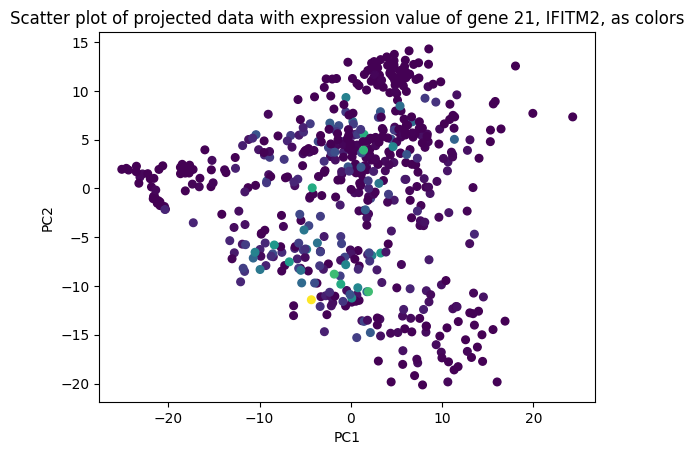

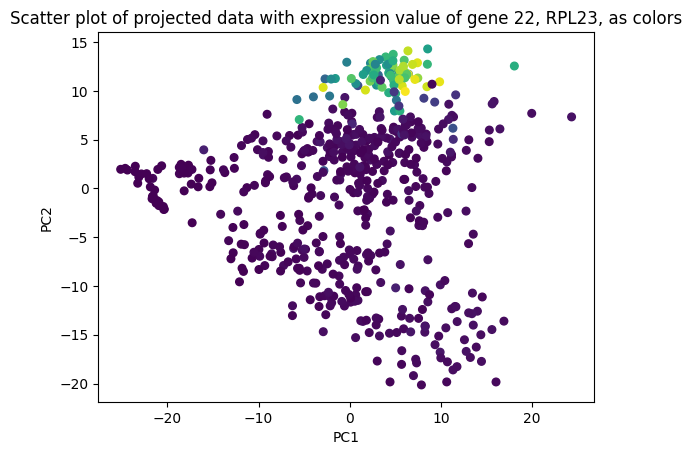

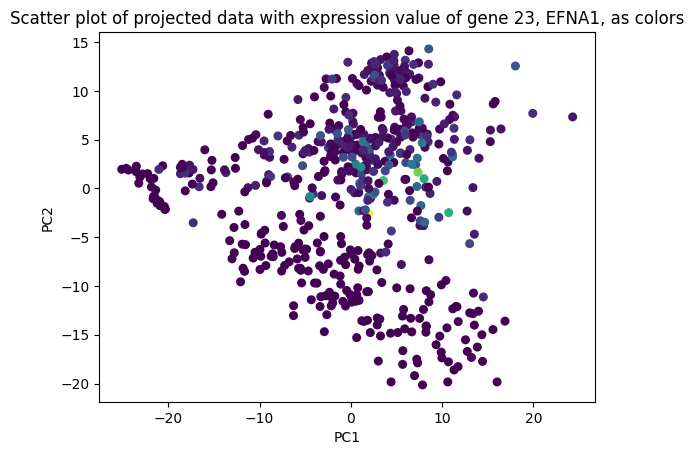

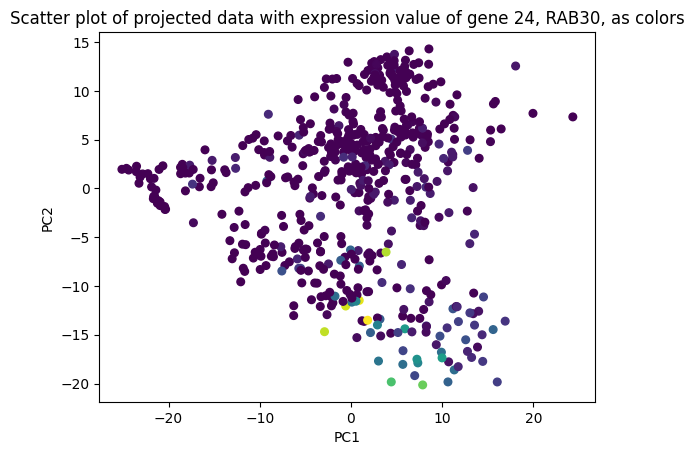

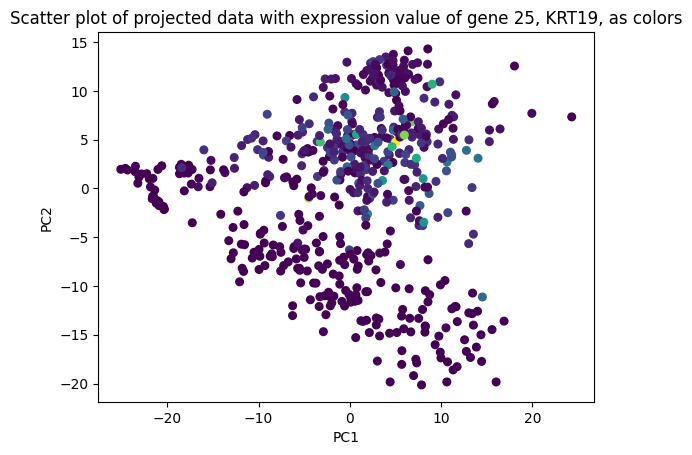

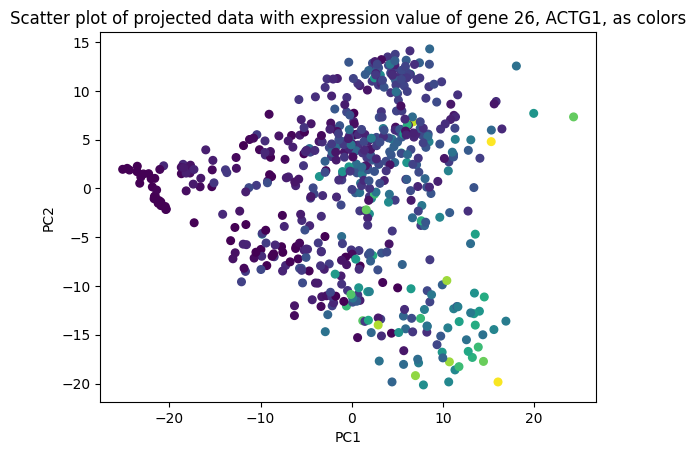

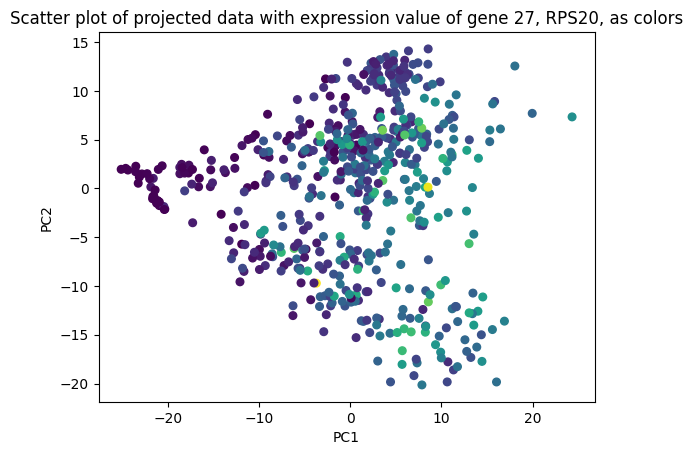

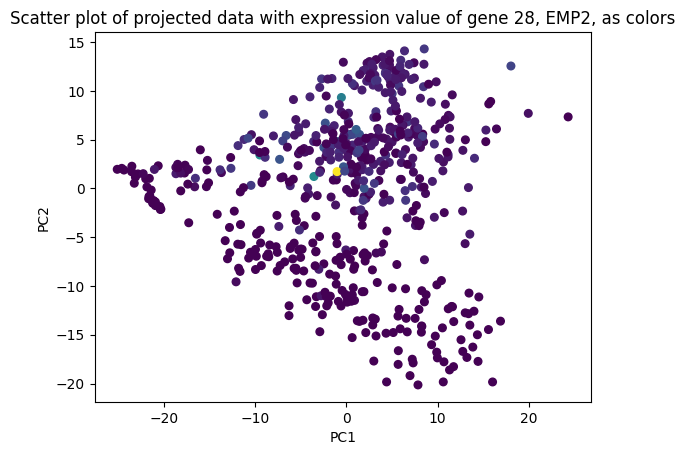

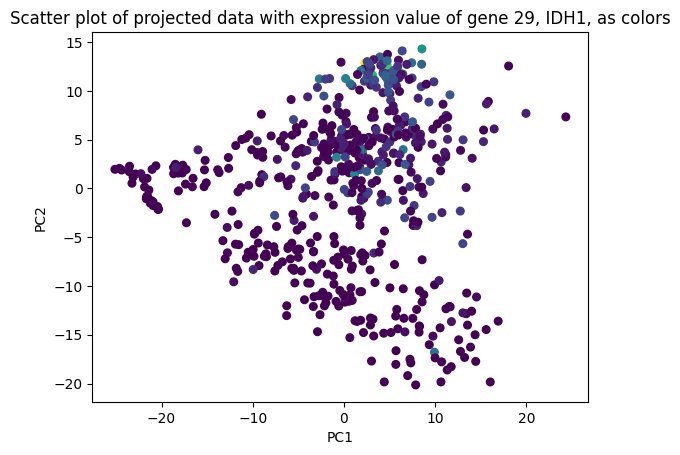

In [107]:
# plot the expression values for top few genes in the scatter plot to see how differetiated its 
# expression is
for i in range(0, 30, 1):
    gene_of_interest_expressions2 = X[:,indices_of_genes_interest2[i]]
    ## scatter plot showing the expression levels of the top 20 found important genes of interest in samples
    plt.scatter(data_X_projected[:, 0], data_X_projected[:, 1], c=gene_of_interest_expressions2, s=30)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'Scatter plot of projected data with expression value of gene {i}, {genes_of_interest2[i]}, as colors')
    plt.show()

In [ ]:
# good genes found - SET in logreg feature selection and few others in random forest